In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pycaret.regression import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import shap

## Variáveis globais

In [3]:
input_csv_path = 'data/NY_HOURLY_RIDERSHIP_2022.csv'
output_csv_path = 'data/NY_AGGREGATED_RIDERSHIP_2022.csv'
holidays_csv_path = 'data/Holidays Dataset US.csv'

In [4]:
chunk_size = 10000
sample_start_date = '2023-01-01'
sample_end_date = '2023-01-03'

## Preprocessamento

In [5]:
def map_hour_to_period(hour):
    if 1 <= hour <= 6:
        return 1
    elif 7 <= hour <= 12:
        return 2
    elif 13 <= hour <= 18:
        return 3
    elif 19 <= hour <= 24 or hour == 0:
        return 4

In [5]:
def preprocess_chunk(chunk_to_process, holiday_dates):
    chunk_to_process = chunk_to_process.copy()

    chunk_to_process = chunk_to_process[(chunk_to_process['transit_timestamp'] >= sample_start_date) & (chunk_to_process['transit_timestamp'] <= sample_end_date)]
    
    chunk_to_process['date'] = chunk_to_process['transit_timestamp'].dt.date
    chunk_to_process['hour'] = chunk_to_process['transit_timestamp'].dt.hour
    chunk_to_process['weekday'] = chunk_to_process['transit_timestamp'].dt.weekday
    chunk_to_process['period'] = chunk_to_process['hour'].apply(map_hour_to_period)
    # chunk_to_process['is_holiday'] = chunk_to_process['date'].apply(lambda x: x in holiday_dates)
    
    return chunk_to_process

In [6]:
def aggregate_chunk(chunk_to_aggregate):
    chunk_to_aggregate = chunk_to_aggregate.copy()

    chunk_to_aggregate = chunk_to_aggregate.groupby(['period', 'weekday', 'station_complex_id']).agg({
        'ridership': 'sum',
    }).reset_index()
    
    return chunk_to_aggregate

In [7]:
holidays_dataset = pd.read_csv(holidays_csv_path)
holidays_dataset = holidays_dataset[holidays_dataset['Type'] == "['National holiday']"]
holidays_dataset['Date'] = pd.to_datetime(holidays_dataset['Date'], errors='coerce')
holiday_dates = set(holidays_dataset['Date'].dt.date)

In [280]:
chunk_iter = pd.read_csv(input_csv_path, chunksize=chunk_size, parse_dates=['transit_timestamp'], date_format='%m/%d/%Y %I:%M:%S %p')

sampled_chunks = []

for chunk in chunk_iter:
    preprocessed_chunk = preprocess_chunk(chunk, holiday_dates)
    grouped_chunk = aggregate_chunk(preprocessed_chunk)

    if not grouped_chunk.empty:
        sampled_chunks.append(grouped_chunk)

In [281]:
df = pd.concat(sampled_chunks)
df = aggregate_chunk(df)

In [282]:
#df.to_csv(output_csv_path, index=False)

In [5]:
df = pd.read_csv(output_csv_path)

In [284]:
tercas_df = df[(df['weekday'] == 2)]
tercas_df = tercas_df.drop('weekday', axis=1)

workday_df = df[df['weekday'].isin([1, 2, 3, 4, 5])]

tercas_df['station_complex_id'] = tercas_df['station_complex_id'].astype(str)
df['station_complex_id'] = df['station_complex_id'].astype(str)
workday_df['station_complex_id'] = workday_df['station_complex_id'].astype(str)
# tercas_df = tercas_df.drop('period', axis=1)

## Modelos isolados

In [7]:
categorical_features = ['station_complex_id', 'weekday']
numeric_features = ['period', 'is_holiday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='poly'))
])

X = df.drop('ridership', axis=1)
y = df['ridership']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Raiz do MSE
mae = mean_absolute_error(y_test, y_pred)  # Erro Absoluto Médio
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# {'poly', 'linear', 'sigmoid', 'rbf', 'precomputed'}

Mean Squared Error: 9917274.449423863
Mean Squared Error (MSE): 9917274.449423863
Root Mean Squared Error (RMSE): 3149.1704382938474
Mean Absolute Error (MAE): 1339.0406778708466
R² Score: -0.0967114142809713


In [129]:
#df = pd.read_csv(output_csv_path)

X = df[['period', 'weekday', 'station_complex_id', 'is_holiday']]
y = df['ridership']

X = pd.get_dummies(X, columns=['weekday', 'station_complex_id'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [10, 20, 30, None],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
                           param_grid=param_grid, 
                           cv=3,  # Number of folds in cross-validation
                           verbose=2,  # Controls the verbosity: the higher, the more messages
                           n_jobs=-1)  # Number of jobs to run in parallel


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Improved Mean Squared Error: {mse}')
print(f'Improved R^2 Score: {r2}')

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Improved Mean Squared Error: 2929370.7528423197
Improved R^2 Score: 0.6760526939445896


## Modelagem com pycaret

In [6]:
setup(data=df, target='ridership', session_id=123, train_size=0.8, categorical_features=['station_complex_id'], normalize=True)

best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,ridership
2,Target type,Regression
3,Original data shape,"(10704, 5)"
4,Transformed data shape,"(10704, 5)"
5,Transformed train set shape,"(8563, 5)"
6,Transformed test set shape,"(2141, 5)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:39:01
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,306.7596,579146.1706,741.7263,0.9355,0.4594,0.5355,1.2730
dt,Decision Tree Regressor,279.6518,646214.9513,787.4577,0.9306,0.4986,0.4921,0.0750
et,Extra Trees Regressor,373.9943,684999.8150,811.7314,0.9218,0.5412,0.6420,1.1090
lightgbm,Light Gradient Boosting Machine,458.3347,1187391.3143,1079.8244,0.8663,0.6055,0.7730,0.5560
gbr,Gradient Boosting Regressor,516.8578,1236398.4100,1104.1273,0.8582,0.8195,1.5300,0.4970
knn,K Neighbors Regressor,538.0373,1918427.3972,1360.2240,0.7863,0.6188,0.7493,0.0970
ada,AdaBoost Regressor,1468.6547,4027220.9208,2002.6201,0.5251,1.7215,10.5769,0.3840
llar,Lasso Least Angle Regression,1121.5622,4875839.9729,2190.7959,0.4578,1.3942,5.8604,0.0790
ridge,Ridge Regression,1121.9461,4875804.1478,2190.7933,0.4578,1.3962,5.8659,0.1410
br,Bayesian Ridge,1121.8810,4875784.3634,2190.7852,0.4578,1.3961,5.8665,0.0750


In [288]:
tuned_model = tune_model(best_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:34:47
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,277.6789,285343.7322,534.1758,0.8511,0.8272,1.5988
1,316.1372,562070.8943,749.7139,0.7675,0.6652,0.8222
2,331.0287,545916.1250,738.8614,0.8365,0.7607,1.1974
3,283.4800,422841.3027,650.2625,0.8175,0.7287,1.5523
4,343.4623,531948.1013,729.3477,0.9322,0.5677,0.6541
5,318.5679,828158.2077,910.0320,0.8927,0.6758,0.9036
6,352.4448,1299633.1647,1140.0145,0.8033,0.6394,0.7709
7,272.3965,310368.4126,557.1072,0.8863,0.6988,1.0053
8,293.2738,505912.0833,711.2750,0.7518,0.7722,1.2968


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,549.3939,1547139.6472,1243.8407,0.8582,0.6805,0.7197


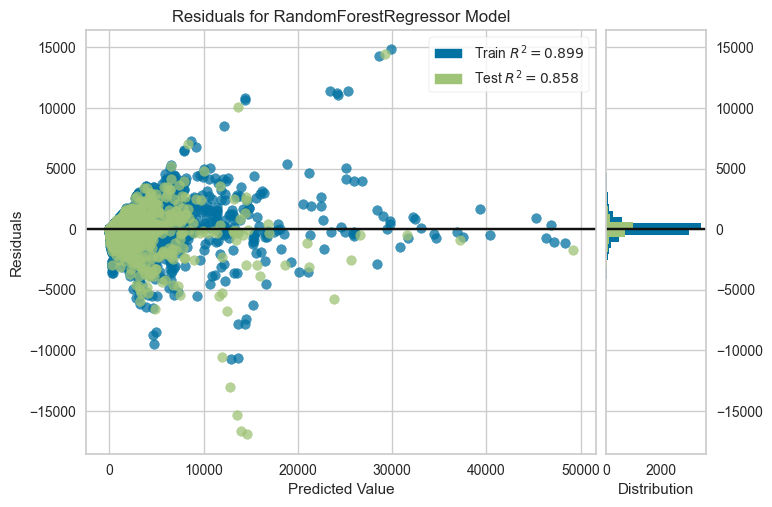

In [141]:
final_model = finalize_model(tuned_model)
predictions = predict_model(final_model)

plot_model(final_model, plot = 'residuals')

In [142]:
evaluate_model(final_model)

metrics = pull()
print(metrics)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

                     Model       MAE           MSE       RMSE      R2   RMSLE  \
0  Random Forest Regressor  549.3939  1.547140e+06  1243.8407  0.8582  0.6805   

     MAPE  
0  0.7197  


## Testes com dados novos

In [79]:
test_start_date = '2023-06-01'
test_end_date = '2023-12-31'

In [292]:
chunk_iter = pd.read_csv(input_csv_path, chunksize=chunk_size, parse_dates=['transit_timestamp'], date_format='%m/%d/%Y %I:%M:%S %p')

new_chunks = []

for chunk in chunk_iter:
    chunk_to_process = chunk[(chunk['transit_timestamp'] >= test_start_date) & (chunk['transit_timestamp'] <= test_end_date)]
    
    chunk_to_process['date'] = chunk_to_process['transit_timestamp'].dt.date
    chunk_to_process['hour'] = chunk_to_process['transit_timestamp'].dt.hour
    chunk_to_process['weekday'] = chunk_to_process['transit_timestamp'].dt.weekday
    chunk_to_process['period'] = chunk_to_process['hour'].apply(map_hour_to_period)
    chunk_to_process['is_holiday'] = chunk_to_process['date'].apply(lambda x: x in holiday_dates)
    
    chunk_to_aggregate = chunk_to_process.groupby(['period', 'weekday', 'station_complex_id']).agg({
        'ridership': 'sum',
    }).reset_index()

    if not chunk_to_aggregate.empty:
        new_chunks.append(chunk_to_aggregate)

In [293]:
test_df = pd.concat(new_chunks)
test_df = test_df.groupby(['period', 'weekday', 'station_complex_id']).agg({
        'ridership': 'sum',
    }).reset_index()

test_terca_df = test_df[test_df['weekday'] == 2]
test_terca_df = test_terca_df.drop('weekday', axis=1)
test_workday_df = test_df[test_df['weekday'].isin([1, 2, 3, 4, 5])]

test_df['station_complex_id'] = test_df['station_complex_id'].astype(str)
test_workday_df['station_complex_id'] = test_workday_df['station_complex_id'].astype(str)
test_terca_df['station_complex_id'] = test_terca_df['station_complex_id'].astype(str)

In [294]:
# Supondo que df1 e df2 sejam seus DataFrames
print("Estatísticas do DataFrame 1:")
print(df['ridership'].describe())

print("\nEstatísticas do DataFrame 2:")
print(test_df['ridership'].describe())


Estatísticas do DataFrame 1:
count     3844.00000
mean       951.46384
std       1954.70569
min          1.00000
25%        131.00000
50%        370.00000
75%        973.25000
max      32279.00000
Name: ridership, dtype: float64

Estatísticas do DataFrame 2:
count    1.201400e+04
mean     4.101942e+04
std      7.654975e+04
min      1.000000e+00
25%      6.623000e+03
50%      1.755800e+04
75%      4.442225e+04
max      1.221652e+06
Name: ridership, dtype: float64


In [295]:
new_predictions = predict_model(final_model, data=test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,40097.6794,7237829153.0393,85075.4321,-0.2353,4.0802,1.0050


In [296]:
# Cálculo das métricas de erro
mae = mean_absolute_error(new_predictions['ridership'], new_predictions['prediction_label'])
mse = mean_squared_error(new_predictions['ridership'], new_predictions['prediction_label'])
rmse = np.sqrt(mse)
r2 = r2_score(new_predictions['ridership'], new_predictions['prediction_label'])

# Exibindo as métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 40097.679355414584
MSE: 7237829153.0393095
RMSE: 85075.4321354838
R²: -0.23525574922350967


In [297]:
print(predictions.head())
print(new_predictions.head())

      period  weekday station_complex_id  ridership  prediction_label
3628       4        6                260        105        225.787434
298        1        0                361        143        123.634988
2417       3        6                336       1186       1277.610268
1411       2        6                158        607       1094.366625
893        2        0                 50        894        976.943902
   period  weekday station_complex_id  ridership  prediction_label
0       1        0                  1      18500        356.959503
1       1        0                  2      12077        185.206269
2       1        0                  3      14388        249.443863
3       1        0                  4      12647        359.008261
4       1        0                  5       6441        196.119985


In [298]:
print(new_predictions[new_predictions['station_complex_id'] == '31'])

       period  weekday station_complex_id  ridership  prediction_label
18          1        0                 31       3393        128.962564
447         1        1                 31       3413        103.477288
876         1        2                 31       3739        103.477288
1305        1        3                 31       3648         74.523273
1734        1        4                 31       3282         90.614312
2163        1        5                 31       1559         90.614312
2592        1        6                 31       1240         90.614312
3021        2        0                 31      22024        585.303297
3450        2        1                 31      24276        485.491570
3879        2        2                 31      25986        485.491570
4308        2        3                 31      25747        328.220860
4737        2        4                 31      21956        344.311899
5167        2        5                 31      12603        344.311899
5596  

## Tentando resolver o problema do overfitting

### Ridge

In [299]:
setup(data=tercas_df, target='ridership', session_id=123, train_size=0.8, categorical_features=['station_complex_id'])

# Criar um modelo de Ridge Regression
ridge = create_model('ridge')

# Ajustar hiperparâmetros do modelo
tuned_ridge = tune_model(ridge, optimize='RMSE')

final_model = finalize_model(tuned_ridge)
predictions = predict_model(final_model)

ValueError: With n_samples=0, test_size=None and train_size=0.8, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
evaluate_model(final_model)

metrics = pull()
print(metrics)

In [ ]:
new_predictions = predict_model(final_model, data=test_terca_df)

# Cálculo das métricas de erro
mae = mean_absolute_error(new_predictions['ridership'], new_predictions['prediction_label'])
mse = mean_squared_error(new_predictions['ridership'], new_predictions['prediction_label'])
rmse = np.sqrt(mse)
r2 = r2_score(new_predictions['ridership'], new_predictions['prediction_label'])

# Exibindo as métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

### Lasso

In [ ]:
setup(data=tercas_df, target='ridership', session_id=123, train_size=0.8, categorical_features=['station_complex_id'])

# Criar um modelo de Lasso Regression
lasso = create_model('lasso')

# Ajustar hiperparâmetros do modelo
tuned_lasso = tune_model(lasso, optimize='RMSE')

final_model = finalize_model(tuned_lasso)
predictions = predict_model(final_model)

In [ ]:
evaluate_model(final_model)

metrics = pull()
print(metrics)

In [ ]:
new_predictions = predict_model(final_model, data=test_terca_df)

# Cálculo das métricas de erro
mae = mean_absolute_error(new_predictions['ridership'], new_predictions['prediction_label'])
mse = mean_squared_error(new_predictions['ridership'], new_predictions['prediction_label'])
rmse = np.sqrt(mse)
r2 = r2_score(new_predictions['ridership'], new_predictions['prediction_label'])

# Exibindo as métricas
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

In [ ]:
print(tercas_df.head())
print(test_terca_df.head())

## Tentando uma abordagem diferente de agrupamento

In [6]:
chunk_size = 50000
base_date = datetime.strptime('2023-01-01', '%Y-%m-%d')
intervals = {
    'one_day': (base_date, base_date + timedelta(days=1)),
    'one_week': (base_date, base_date + timedelta(weeks=1)),
    'one_month': (base_date, base_date + timedelta(days=30)),
    'two_months': (base_date, base_date + timedelta(days=30*2)),
    'three_months': (base_date, base_date + timedelta(days=30*3)),
    'five_months': (base_date, base_date + timedelta(days=30*5))
}

In [7]:
def process_interval(start_date, end_date):
    iterator = pd.read_csv(input_csv_path, chunksize=chunk_size, parse_dates=['transit_timestamp'], date_format='%Y-%m-%d %H:%M:%S')
    
    chunks_to_save = []
    unique_days = []

    for current_chunk in iterator:
        current_chunk['transit_timestamp'] = pd.to_datetime(current_chunk['transit_timestamp'], format='%m/%d/%Y %I:%M:%S %p', errors='raise')
        
        chunk_being_processed = current_chunk[(current_chunk['transit_timestamp'] >= start_date) & (current_chunk['transit_timestamp'] < end_date)]
        chunk_being_processed['date'] = chunk_being_processed['transit_timestamp'].dt.date
        chunk_being_processed['hour'] = chunk_being_processed['transit_timestamp'].dt.hour
        chunk_being_processed['weekday'] = chunk_being_processed['transit_timestamp'].dt.weekday
        chunk_being_processed['period'] = chunk_being_processed['hour'].apply(map_hour_to_period)
        
        chunk_being_grouped = chunk_being_processed.groupby(['period', 'weekday', 'station_complex_id']).agg({
            'ridership': 'sum',
            'latitude': 'first',
            'longitude': 'first'
        }).reset_index()

        if not chunk_being_grouped.empty:
            chunks_to_save.append(chunk_being_grouped)
            unique_days.append(chunk_being_processed['date'].unique())

    dataframe = pd.concat(chunks_to_save)
    dataframe = dataframe.groupby(['period', 'weekday', 'station_complex_id']).agg({
        'ridership': 'sum',
        'latitude': 'first',
        'longitude': 'first'
    }).reset_index()
    
    dataframe['days_count'] = len(set([item for sublist in unique_days for item in sublist]))
    
    return dataframe

In [ ]:
all_intervals_df = []
for label, (start, end) in intervals.items():
    print(f"Initiating processing of interval {start} to {end}")
    
    interval_df = process_interval(start, end)
    print(interval_df['days_count'].unique())
    
    all_intervals_df.append(interval_df)

final_df = pd.concat(all_intervals_df)

In [ ]:
final_df = final_df.reset_index()

final_df['station_complex_id'] = final_df['station_complex_id'].astype(str)
final_df = final_df.drop('index', axis=1)

rapidao = final_df.drop('latitude', axis=1)
rapidao = rapidao.drop('longitude', axis=1)

In [2]:
# final_df.to_csv("data/my_new_attempt.csv", index=False)

final_df = pd.read_csv("data/my_new_attempt.csv")

In [7]:
print(final_df['ridership'].describe())

count    6.186700e+04
mean     1.674515e+04
std      4.176931e+04
min      1.000000e+00
25%      1.282500e+03
50%      4.677000e+03
75%      1.537950e+04
max      1.139348e+06
Name: ridership, dtype: float64


In [9]:
setup(data=final_df, target='ridership', session_id=123, train_size=0.8, categorical_features=['station_complex_id'], normalize=True)

best_model = compare_models()

,Description,Value
0,Session id,123
1,Target,ridership
2,Target type,Regression
3,Original data shape,"(61867, 7)"
4,Transformed data shape,"(61867, 7)"
5,Transformed train set shape,"(49493, 7)"
6,Transformed test set shape,"(12374, 7)"
7,Numeric features,5
8,Categorical features,1
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:56:35
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1641.6200,34700254.4875,5868.1294,0.9797,0.4311,4.7943,4.8350
rf,Random Forest Regressor,1610.5860,35752396.4176,5934.4778,0.9793,0.3417,4.2446,5.4860
lightgbm,Light Gradient Boosting Machine,2885.8397,53795203.2717,7305.6489,0.9686,0.7343,4.0278,0.5540
dt,Decision Tree Regressor,1910.4592,62205728.0510,7803.9385,0.9632,0.4622,4.8472,0.1550
knn,K Neighbors Regressor,3877.6819,146317207.0877,12004.5114,0.9151,0.5250,4.1334,0.1780
gbr,Gradient Boosting Regressor,6457.4071,253729732.9976,15871.9062,0.8526,1.1882,6.7889,2.0620
lar,Least Angle Regression,15139.9749,1044545957.4030,32176.8452,0.3968,1.8705,18.6546,0.0990
br,Bayesian Ridge,15138.4782,1044542130.6935,32176.7627,0.3968,1.8705,18.6496,0.1150
llar,Lasso Least Angle Regression,15139.3480,1044544561.8986,32176.8159,0.3968,1.8701,18.6521,0.1010
ridge,Ridge Regression,15139.8038,1044545509.8255,32176.8356,0.3968,1.8705,18.6540,0.0960


In [10]:
tuned_model = tune_model(best_model)        

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:21:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:21:54
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


Fitting 10 folds for each of 10 candidates, totalling 100 fits



KeyboardInterrupt



In [12]:
final_model = finalize_model(best_model)
predictions = predict_model(final_model)

#plot_model(final_model, plot = 'residuals')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1376.0697,26869986.6351,5183.6268,0.9851,0.2953,1.8865


In [13]:
evaluate_model(final_model)

metrics = pull()
print(metrics)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

                   Model        MAE           MSE       RMSE      R2   RMSLE  \
0  Extra Trees Regressor  1376.0697  2.686999e+07  5183.6268  0.9851  0.2953   

     MAPE  
0  1.8865  


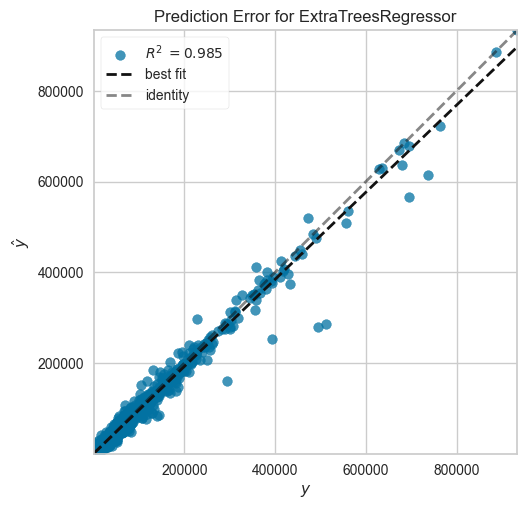

KeyboardInterrupt: 

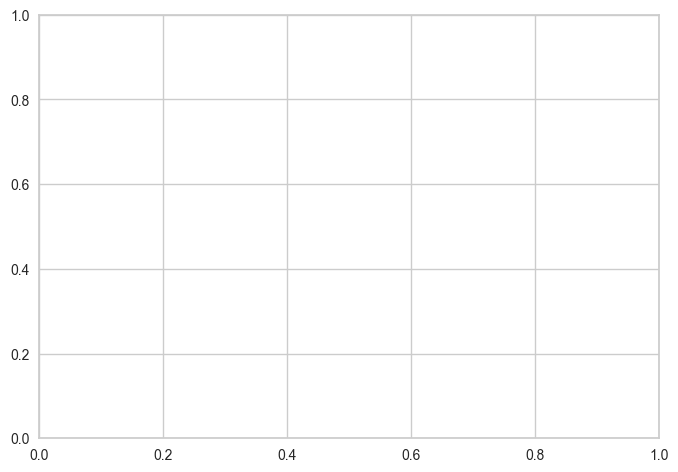

In [14]:
plot_model(final_model, plot = 'error')
plot_model(final_model, plot = 'learning')

In [49]:
test_base_date = datetime.strptime('2023-06-01', '%Y-%m-%d')
test_intervals = {
    'one_day': (test_base_date, test_base_date + timedelta(days=1)),
    'one_week': (test_base_date, test_base_date + timedelta(weeks=1)),
    'one_month': (test_base_date, test_base_date + timedelta(days=30)),
    'two_months': (test_base_date, test_base_date + timedelta(days=30*2)),
    'three_months': (test_base_date, test_base_date + timedelta(days=30*3)),
    'five_months': (test_base_date, test_base_date + timedelta(days=30*5))
}

In [36]:
all_intervals_df = []
for label, (start, end) in test_intervals.items():
    print(f"Initiating processing of interval {start} to {end}")
    
    interval_df = process_interval(start, end)
    print(interval_df['days_count'].unique())
    
    all_intervals_df.append(interval_df)

test_df = pd.concat(all_intervals_df)

Initiating processing of interval 2023-06-01 00:00:00 to 2023-06-02 00:00:00
[1]
Initiating processing of interval 2023-06-01 00:00:00 to 2023-06-08 00:00:00
[7]
Initiating processing of interval 2023-06-01 00:00:00 to 2023-07-01 00:00:00
[30]
Initiating processing of interval 2023-06-01 00:00:00 to 2023-07-31 00:00:00
[60]
Initiating processing of interval 2023-06-01 00:00:00 to 2023-08-30 00:00:00
[90]
Initiating processing of interval 2023-06-01 00:00:00 to 2023-10-29 00:00:00
[150]


In [50]:
test_df = test_df.reset_index()

test_df['station_complex_id'] = test_df['station_complex_id'].astype(str)
test_df = test_df.drop('index', axis=1)

test_rapidao = test_df.drop('latitude', axis=1)
test_rapidao = test_rapidao.drop('longitude', axis=1)

In [138]:
new_predictions = predict_model(final_model, data=test_df[test_df['days_count'] == 1])

cur_test = test_df[test_df['days_count'] == 1]
print(cur_test.tail())
print(new_predictions.tail())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,687.0270,2137051.9125,1461.8659,0.8751,0.4177,0.3394


      period  weekday station_complex_id  ridership   latitude  longitude  \
1715       4        3                636       3588  40.692337 -73.985939   
1716       4        3                 98        190  40.700260 -73.941124   
1717       4        3                 99        416  40.703869 -73.947411   
1718       4        3              TRAM1        818  40.761338 -73.964155   
1719       4        3              TRAM2        567  40.757340 -73.954114   

      days_count  
1715           1  
1716           1  
1717           1  
1718           1  
1719           1  
      period  weekday station_complex_id   latitude  longitude  days_count  \
1715       4        3                636  40.692337 -73.985939           1   
1716       4        3                 98  40.700260 -73.941124           1   
1717       4        3                 99  40.703869 -73.947411           1   
1718       4        3              TRAM1  40.761337 -73.964157           1   
1719       4        3            

In [106]:
print(final_df['days_count'].unique())
print(test_df['days_count'].unique())
print(new_predictions)

[  1   7  30  60  90 150]
[  1   7  30  60  90 150]
       period  weekday station_complex_id   latitude  longitude  days_count  \
0           1        3                  1  40.775036 -73.912033           1   
1           1        3                  2  40.770260 -73.917847           1   
2           1        3                  3  40.766781 -73.921478           1   
3           1        3                  4  40.761822 -73.925507           1   
4           1        3                  5  40.756805 -73.929573           1   
...       ...      ...                ...        ...        ...         ...   
73611       4        6                 97  40.697208 -73.935654         150   
73612       4        6                 98  40.700260 -73.941124         150   
73613       4        6                 99  40.703869 -73.947411         150   
73614       4        6              TRAM1  40.761337 -73.964157         150   
73615       4        6              TRAM2  40.757339 -73.954117         150   


## Testando multiplos modelos

In [107]:
setup(data=final_df, target='ridership', session_id=123, train_size=0.8, categorical_features=['station_complex_id'], normalize=True)

top_models = compare_models(n_select=6)

results = {}
for model in top_models:
    predictions = predict_model(model, data=test_df)
    actual_values = test_df['ridership']
    predicted_values = predictions['prediction_label']
    mse = mean_squared_error(actual_values, predicted_values)
    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual_values, predicted_values)
    
    results[model.__class__.__name__] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

print("Performance dos modelos no conjunto de validação externo:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.2f}")
    print()

,Description,Value
0,Session id,123
1,Target,ridership
2,Target type,Regression
3,Original data shape,"(61867, 7)"
4,Transformed data shape,"(61867, 7)"
5,Transformed train set shape,"(49493, 7)"
6,Transformed test set shape,"(12374, 7)"
7,Numeric features,5
8,Categorical features,1
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:06:10
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1641.6200,34700254.4875,5868.1294,0.9797,0.4311,4.7943,5.2520
rf,Random Forest Regressor,1610.5860,35752396.4176,5934.4778,0.9793,0.3417,4.2446,7.2380
lightgbm,Light Gradient Boosting Machine,2885.8397,53795203.2717,7305.6489,0.9686,0.7343,4.0278,0.3760
dt,Decision Tree Regressor,1910.4592,62205728.0510,7803.9385,0.9632,0.4622,4.8472,0.2090
knn,K Neighbors Regressor,3877.6819,146317207.0877,12004.5114,0.9151,0.5250,4.1334,0.2610
gbr,Gradient Boosting Regressor,6457.4071,253729732.9976,15871.9062,0.8526,1.1882,6.7889,1.8720
lar,Least Angle Regression,15139.9749,1044545957.4030,32176.8452,0.3968,1.8705,18.6546,0.0910
br,Bayesian Ridge,15138.4782,1044542130.6935,32176.7627,0.3968,1.8705,18.6496,0.0980
llar,Lasso Least Angle Regression,15139.3480,1044544561.8986,32176.8159,0.3968,1.8701,18.6521,0.0910
ridge,Ridge Regression,15139.8038,1044545509.8255,32176.8356,0.3968,1.8705,18.6540,0.0990


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7608.0710,805788441.3997,28386.4130,0.3798,0.8057,4.4010


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,7585.5233,791497477.8264,28133.5650,0.3908,0.7960,4.3255


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,8178.2019,777757527.5246,27888.3045,0.4013,1.0074,5.1278


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Decision Tree Regressor,7627.8377,810194873.0327,28463.9223,0.3764,0.8065,4.2604


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8308.1150,785260768.7139,28022.5047,0.3956,0.8721,4.5713


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,10314.5059,668978325.8424,25864.6153,0.4851,1.3238,9.5533


Performance dos modelos no conjunto de validação externo:
ExtraTreesRegressor:
  MSE: 805788441.40
  MAE: 7608.07
  RMSE: 28386.41
  R²: 0.38

RandomForestRegressor:
  MSE: 791497477.83
  MAE: 7585.52
  RMSE: 28133.56
  R²: 0.39

LGBMRegressor:
  MSE: 777757527.52
  MAE: 8178.20
  RMSE: 27888.30
  R²: 0.40

DecisionTreeRegressor:
  MSE: 810194873.03
  MAE: 7627.84
  RMSE: 28463.92
  R²: 0.38

KNeighborsRegressor:
  MSE: 785260768.71
  MAE: 8308.12
  RMSE: 28022.50
  R²: 0.40

GradientBoostingRegressor:
  MSE: 668978325.84
  MAE: 10314.51
  RMSE: 25864.62
  R²: 0.49



In [119]:
print(final_df[(final_df['weekday'] == 2) & (final_df['days_count'] == 1)].head())

   period  weekday station_complex_id  ridership   latitude  longitude  \
0       1        6                  1        240  40.775036 -73.912033   
1       1        6                  2        195  40.770260 -73.917847   
2       1        6                  3        291  40.766781 -73.921478   
3       1        6                  4        297  40.761822 -73.925507   
4       1        6                  5        167  40.756805 -73.929573   

   days_count  
0           1  
1           1  
2           1  
3           1  
4           1  


In [122]:
tercas_df = final_df[(final_df['weekday'] == 2) & (final_df['days_count'] == 7)]
tercas_df = tercas_df.drop('weekday', axis=1)
tercas_df = tercas_df.drop('days_count', axis=1)
tercas_df['station_complex_id'] = tercas_df['station_complex_id'].astype(str)

setup(data=tercas_df, target='ridership', session_id=123, train_size=0.8, categorical_features=['station_complex_id'], normalize=True)

best_model = compare_models()
final_model = finalize_model(best_model)
predictions = predict_model(final_model)
evaluate_model(final_model)

,Description,Value
0,Session id,123
1,Target,ridership
2,Target type,Regression
3,Original data shape,"(1717, 5)"
4,Transformed data shape,"(1717, 5)"
5,Transformed train set shape,"(1373, 5)"
6,Transformed test set shape,"(344, 5)"
7,Numeric features,3
8,Categorical features,1
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:30:15
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,994.1576,5345668.6126,2176.0865,0.5507,0.7580,2.4454,0.2200
et,Extra Trees Regressor,972.3963,6219703.0482,2273.3964,0.5219,0.6839,1.9785,0.3560
rf,Random Forest Regressor,1000.0506,6148360.2883,2325.4063,0.5033,0.6611,2.1207,0.4480
knn,K Neighbors Regressor,966.5517,6475592.3714,2394.8364,0.4565,0.6355,2.1464,0.0680
lightgbm,Light Gradient Boosting Machine,989.4432,6231200.0851,2397.9366,0.4545,0.6594,2.2314,0.2130
dt,Decision Tree Regressor,1083.4663,7336192.3452,2475.2435,0.4350,0.7488,2.0339,0.0670
en,Elastic Net,1638.9331,9967821.3212,3034.6842,0.1632,1.3212,4.2064,0.0860
ada,AdaBoost Regressor,1751.4639,9924068.5012,3001.3446,0.1299,1.3738,5.1501,0.1210
huber,Huber Regressor,1649.7263,10537997.2127,3135.9111,0.0848,1.2478,3.2721,0.0670
par,Passive Aggressive Regressor,1648.5890,10630924.4395,3150.8023,0.0754,1.2477,3.0600,0.0630


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,826.0531,4041899.7910,2010.4477,0.7733,0.6868,0.6475


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [124]:
metrics = pull()
print(metrics)

test_tercas_df = test_df[(test_df['weekday'] == 2) & (test_df['days_count'] == 7)]
test_tercas_df = test_tercas_df.drop('weekday', axis=1)
test_tercas_df = test_tercas_df.drop('days_count', axis=1)
test_tercas_df['station_complex_id'] = test_tercas_df['station_complex_id'].astype(str)

                         Model       MAE          MSE       RMSE      R2  \
0  Gradient Boosting Regressor  826.0531  4041899.791  2010.4477  0.7733   

    RMSLE    MAPE  
0  0.6868  0.6475  


In [125]:
new_predictions = predict_model(final_model, data=test_tercas_df)
metrics = pull()
print(metrics)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,530.4386,1282128.9777,1132.3113,0.9273,0.5660,0.4498


                         Model       MAE           MSE       RMSE      R2  \
0  Gradient Boosting Regressor  530.4386  1.282129e+06  1132.3113  0.9273   

   RMSLE    MAPE  
0  0.566  0.4498  
